In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('RFLFSODataFull.csv')

In [3]:
fso_data = data.drop("RFL_Att", axis = 1).copy()

[Baseline] RMSE=0.282, R²=0.995
▷ 尝试移除 Frequency: ΔRMSE=-0.000, ΔR²=-0.000
▷ 尝试移除 RainIntensityMin: ΔRMSE=-0.001, ΔR²=0.000
▷ 尝试移除 RainIntensityMax: ΔRMSE=-0.000, ΔR²=0.000
▷ 尝试移除 WindDirection: ΔRMSE=0.000, ΔR²=-0.000
▷ 尝试移除 RainIntensity: ΔRMSE=-0.004, ΔR²=0.000
▷ 尝试移除 WindSpeedMin: ΔRMSE=-0.000, ΔR²=0.000
▷ 尝试移除 AbsoluteHumidityMin: ΔRMSE=-0.000, ΔR²=0.000
▷ 尝试移除 AbsoluteHumidityMax: ΔRMSE=-0.002, ΔR²=0.000
▷ 尝试移除 WindSpeed: ΔRMSE=-0.004, ΔR²=0.000
▷ 尝试移除 WindSpeedMax: ΔRMSE=0.004, ΔR²=-0.000
▷ 尝试移除 TemperatureMax: ΔRMSE=0.006, ΔR²=-0.000
▷ 尝试移除 VisibilityMax: ΔRMSE=-0.003, ΔR²=0.000
▷ 尝试移除 TemperatureDifference: ΔRMSE=-0.002, ΔR²=0.000
▷ 尝试移除 ParticulateMax: ΔRMSE=0.029, ΔR²=-0.001
▷ 尝试移除 RelativeHumidity: ΔRMSE=-0.000, ΔR²=0.000
▷ 尝试移除 Time: ΔRMSE=-0.001, ΔR²=0.000
▷ 尝试移除 TemperatureMin: ΔRMSE=0.092, ΔR²=-0.004
▷ 尝试移除 Particulate: ΔRMSE=-0.003, ΔR²=0.000
▷ 尝试移除 AbsoluteHumidity: ΔRMSE=0.001, ΔR²=-0.000
▷ 尝试移除 VisibilityMin: ΔRMSE=0.094, ΔR²=-0.005
▷ 尝试移除 ParticulateMin: ΔRMSE=-0.0

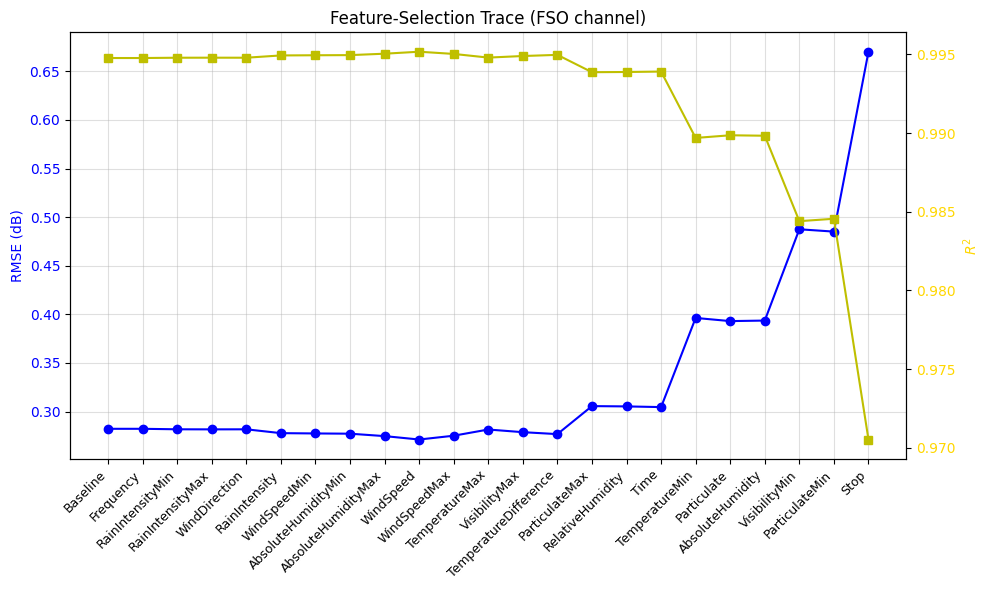


— 选择结果 —
保留特征: ['Distance', 'Temperature', 'Visibility']
移除特征: ['Frequency', 'RainIntensityMin', 'RainIntensityMax', 'WindDirection', 'RainIntensity', 'WindSpeedMin', 'AbsoluteHumidityMin', 'AbsoluteHumidityMax', 'WindSpeed', 'WindSpeedMax', 'TemperatureMax', 'VisibilityMax', 'TemperatureDifference', 'ParticulateMax', 'RelativeHumidity', 'Time', 'TemperatureMin', 'Particulate', 'AbsoluteHumidity', 'VisibilityMin', 'ParticulateMin']
决策记录:
  · Removed Frequency
  · Removed RainIntensityMin
  · Removed RainIntensityMax
  · Removed WindDirection
  · Removed RainIntensity
  · Removed WindSpeedMin
  · Removed AbsoluteHumidityMin
  · Removed AbsoluteHumidityMax
  · Removed WindSpeed
  · Removed WindSpeedMax
  · Removed TemperatureMax
  · Removed VisibilityMax
  · Removed TemperatureDifference
  · Removed ParticulateMax
  · Removed RelativeHumidity
  · Removed Time
  · Removed TemperatureMin
  · Removed Particulate
  · Removed AbsoluteHumidity
  · Removed VisibilityMin
  · Removed Particulate

In [4]:
def feature_selection(data, target_column,
                      drop_columns=None,
                      rmse_threshold=0.10,
                      r2_threshold=0.02):
    if drop_columns is None:
        drop_columns = []

    drop_columns = list(set(drop_columns) | {'SYNOPCode'})
    data = data.drop(columns=drop_columns, errors='ignore')

    X = data.drop(columns=[target_column])
    y = data[target_column]

    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    rmse_list, r2_list = [], []
    removed_features, decisions = [], []
    current_feats = list(X.columns)

    # —— baseline
    rf.fit(X[current_feats], y)
    y_pred = rf.predict(X[current_feats])
    base_rmse = sqrt(mean_squared_error(y, y_pred))
    base_r2   = r2_score(y, y_pred)
    rmse_list.append(base_rmse)
    r2_list.append(base_r2)
    print(f"[Baseline] RMSE={base_rmse:.3f}, R²={base_r2:.3f}")

    while len(current_feats) > 1:
        rf.fit(X[current_feats], y)
        y_pred = rf.predict(X[current_feats])
        rmse = sqrt(mean_squared_error(y, y_pred))
        r2   = r2_score(y, y_pred)
        rmse_list.append(rmse)
        r2_list.append(r2)

        # 找到最小重要性的特征
        worst_idx  = np.argmin(rf.feature_importances_)
        worst_feat = current_feats[worst_idx]

        rmse_inc = rmse - base_rmse
        r2_dec   = base_r2 - r2
        print(f"▷ 尝试移除 {worst_feat}: ΔRMSE={rmse_inc:.3f}, ΔR²={-r2_dec:.3f}")

        if (rmse_inc > rmse_threshold) or (r2_dec > r2_threshold):
            decisions.append(f"Stop @ {worst_feat} (ΔRMSE={rmse_inc:.3f}, ΔR²={-r2_dec:.3f})")
            break

        # 真正移除
        removed_features.append(worst_feat)
        decisions.append(f"Removed {worst_feat}")
        current_feats.pop(worst_idx)
        base_rmse, base_r2 = rmse, r2

    # ─── 画图 ───
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(rmse_list, 'b-o', label='RMSE')
    ax1.set_ylabel('RMSE (dB)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(alpha=0.4)

    ax2 = ax1.twinx()
    ax2.plot(r2_list, 'y-s', label='$R^2$')
    ax2.set_ylabel('$R^2$', color='gold')
    ax2.tick_params(axis='y', labelcolor='gold')

    labels = ['Baseline'] + removed_features
    if len(labels) < len(rmse_list):
        labels.append('Stop')
    ax1.set_xticks(range(len(rmse_list)))
    ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)

    plt.title('Feature-Selection Trace (FSO channel)')
    fig.tight_layout()
    plt.show()

    print("\n— 选择结果 —")
    print("保留特征:", current_feats)
    print("移除特征:", removed_features)
    print("决策记录:")
    for d in decisions:
        print("  ·", d)

    return current_feats

# ───────────────────────────────────────────────────────────────
# ❷  通用 Random-Forest 评估
# ───────────────────────────────────────────────────────────────
def evaluate_general(data, target_column, features):
    X, y = data[features], data[target_column]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.30, random_state=42)

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    gs = GridSearchCV(RandomForestRegressor(random_state=42),
                      param_grid, cv=3,
                      scoring='neg_mean_squared_error',
                      n_jobs=-1)
    gs.fit(X_tr, y_tr)
    best = gs.best_estimator_
    print("\n最优超参数:", gs.best_params_)

    # 训练集
    tr_pred = best.predict(X_tr)
    tr_rmse = sqrt(mean_squared_error(y_tr, tr_pred))
    tr_r2   = r2_score(y_tr, tr_pred)
    # 测试集
    te_pred = best.predict(X_te)
    te_rmse = sqrt(mean_squared_error(y_te, te_pred))
    te_r2   = r2_score(y_te, te_pred)

    print(f"训练集 → RMSE={tr_rmse:.3f}, R²={tr_r2:.3f}")
    print(f"测试集 → RMSE={te_rmse:.3f}, R²={te_r2:.3f}")
    return best, gs.best_params_, tr_rmse, tr_r2, te_rmse, te_r2

# ───────────────────────────────────────────────────────────────
# ❸  示例调用
# ───────────────────────────────────────────────────────────────
# 假设 fso_data 已经是包含 FSO_Att 与所有气象特征的 DataFrame
# fso_data = pd.read_csv('your_fso_dataset.csv')

important_feats = feature_selection(
    data=fso_data,
    target_column='FSO_Att',
    drop_columns=[],            # 其它想一起排除的列
    rmse_threshold=0.10,
    r2_threshold=0.02
)

general_model, params, tr_rmse, tr_r2, te_rmse, te_r2 = evaluate_general(
    data=fso_data,
    target_column='FSO_Att',
    features=important_feats
)

print("\n—— 汇总 ——")
print("最终保留特征:", important_feats)
print("最优参数:", params)
print(f"Test RMSE={te_rmse:.3f}, R²={te_r2:.3f}")


In [5]:
# ④ ───────────────── 分天气评估 ───────────────────────────
def per_weather_scores(model, data, target_column, features, code_col='SYNOPCode'):
    results = []
    for code, grp in data.groupby(code_col):
        if len(grp) < 3:          # 数据太少可跳过
            continue
        X_g = grp[features]
        y_g = grp[target_column]
        pred = model.predict(X_g)
        rmse = sqrt(mean_squared_error(y_g, pred))
        r2   = r2_score(y_g, pred)
        results.append({'Code': code, 'Samples': len(grp),
                        'RMSE': round(rmse, 3), 'R2': round(r2, 3)})
    return pd.DataFrame(results)

per_weather_df = per_weather_scores(general_model,
                                    fso_data,       # 原始全集
                                    target_column='FSO_Att',
                                    features=important_feats,
                                    code_col='SYNOPCode')

print("\n— Generic FSO 模型：分天气测试性能 —")
print(per_weather_df)


— Generic FSO 模型：分天气测试性能 —
   Code  Samples   RMSE     R2
0     0    56964  1.228  0.878
1     3      191  1.879  0.947
2     4      466  1.344  0.884
3     5     6605  1.372  0.853
4     6    25018  1.621  0.859
5     7      419  3.536  0.553
6     8     1716  1.317  0.890


In [6]:
rf_data = data.drop("FSO_Att", axis = 1).copy()
rf_data['SYNOPCode'] = rf_data['SYNOPCode'].astype('category')

[Baseline] RMSE=0.179, R²=0.997
▷ 尝试删 WindDirection: ΔRMSE=0.000, ΔR²=-0.000
▷ 尝试删 WindSpeedMin: ΔRMSE=-0.002, ΔR²=0.000
▷ 尝试删 WindSpeed: ΔRMSE=0.000, ΔR²=-0.000
▷ 尝试删 WindSpeedMax: ΔRMSE=-0.000, ΔR²=0.000
▷ 尝试删 AbsoluteHumidityMax: ΔRMSE=-0.001, ΔR²=0.000
▷ 尝试删 TemperatureMin: ΔRMSE=-0.002, ΔR²=0.000
▷ 尝试删 AbsoluteHumidityMin: ΔRMSE=-0.003, ΔR²=0.000
▷ 尝试删 Particulate: ΔRMSE=-0.004, ΔR²=0.000
▷ 尝试删 VisibilityMin: ΔRMSE=0.001, ΔR²=-0.000
▷ 尝试删 ParticulateMin: ΔRMSE=-0.001, ΔR²=0.000
▷ 尝试删 TemperatureDifference: ΔRMSE=-0.000, ΔR²=0.000
▷ 尝试删 Time: ΔRMSE=0.013, ΔR²=-0.000
▷ 尝试删 VisibilityMax: ΔRMSE=0.029, ΔR²=-0.001
▷ 尝试删 Frequency: ΔRMSE=-0.001, ΔR²=0.000
▷ 尝试删 TemperatureMax: ΔRMSE=0.059, ΔR²=-0.002
▷ 尝试删 RelativeHumidity: ΔRMSE=-0.001, ΔR²=0.000
▷ 尝试删 Visibility: ΔRMSE=0.004, ΔR²=-0.000
▷ 尝试删 RainIntensityMin: ΔRMSE=0.030, ΔR²=-0.001
▷ 尝试删 ParticulateMax: ΔRMSE=-0.000, ΔR²=0.000
▷ 尝试删 Temperature: ΔRMSE=0.017, ΔR²=-0.001
▷ 尝试删 RainIntensityMax: ΔRMSE=0.077, ΔR²=-0.005
▷ 尝试删 Distance: 

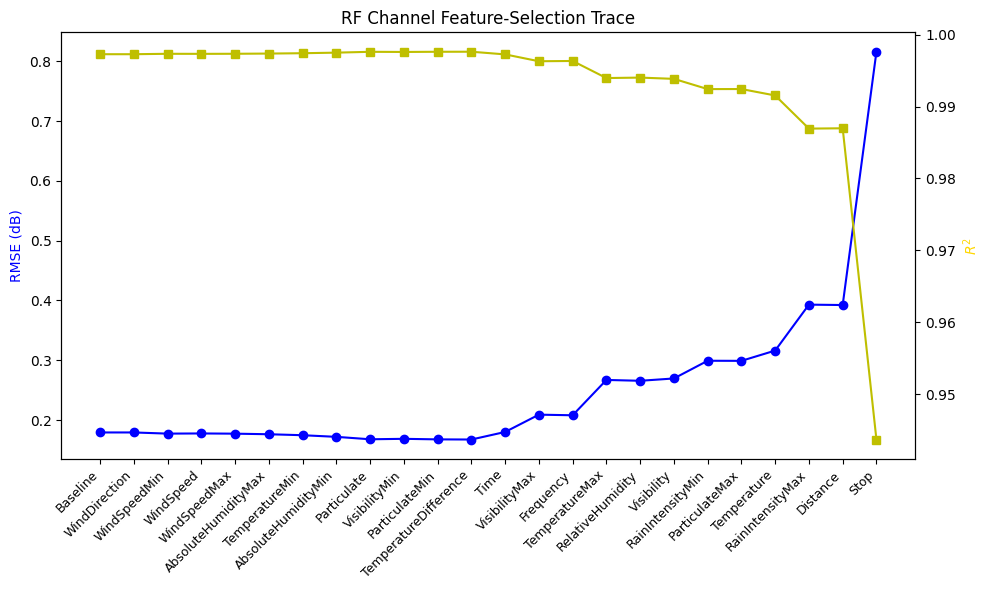


保留特征: ['AbsoluteHumidity', 'RainIntensity']
最优参数: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
训练 RMSE=1.763, R²=0.738
测试 RMSE=1.869, R²=0.702

—— 全局测试性能 ——
RMSE=1.869, R²=0.702


C:\Users\KAIZHAO\AppData\Local\Temp\ipykernel_35292\1906413908.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for code,g in data.groupby(code_col):



—— 分天气性能 ——
   Code  Samples   RMSE     R2
0     0    56964  1.931  0.429
1     3      191  1.344  0.799
2     4      466  0.823  0.756
3     5     6605  1.255  0.810
4     6    25018  1.629  0.838
5     7      419  0.717  0.781
6     8     1716  1.644  0.714


In [7]:
def feature_selection(data, target,
                      drop_cols=None,
                      rmse_thr=0.10, r2_thr=0.02):
    if drop_cols is None:
        drop_cols = []
    drop_cols = list(set(drop_cols) | {'SYNOPCode'})   # 强行丢掉
    data = data.drop(columns=drop_cols, errors='ignore')

    X, y = data.drop(columns=[target]), data[target]
    rf = RandomForestRegressor(n_estimators=100,
                               random_state=42,
                               n_jobs=-1)

    feats_now = list(X.columns)
    rmse_list, r2_list = [], []
    removed, decisions = [], []

    # baseline
    rf.fit(X[feats_now], y)
    base_rmse = sqrt(mean_squared_error(y, rf.predict(X[feats_now])))
    base_r2   = r2_score(y, rf.predict(X[feats_now]))
    rmse_list.append(base_rmse); r2_list.append(base_r2)
    print(f"[Baseline] RMSE={base_rmse:.3f}, R²={base_r2:.3f}")

    while len(feats_now) > 1:
        rf.fit(X[feats_now], y)
        rmse = sqrt(mean_squared_error(y, rf.predict(X[feats_now])))
        r2   = r2_score(y, rf.predict(X[feats_now]))
        rmse_list.append(rmse); r2_list.append(r2)

        worst_idx  = np.argmin(rf.feature_importances_)
        worst_feat = feats_now[worst_idx]
        rmse_inc = rmse - base_rmse
        r2_dec   = base_r2 - r2
        print(f"▷ 尝试删 {worst_feat}: ΔRMSE={rmse_inc:.3f}, ΔR²={-r2_dec:.3f}")

        if rmse_inc > rmse_thr or r2_dec > r2_thr:
            decisions.append(f"Stop @ {worst_feat}")
            break

        removed.append(worst_feat)
        decisions.append(f"Removed {worst_feat}")
        feats_now.pop(worst_idx)
        base_rmse, base_r2 = rmse, r2

    # —— 曲线图
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(rmse_list, 'b-o'); ax1.set_ylabel('RMSE (dB)', color='blue')
    ax2 = ax1.twinx(); ax2.plot(r2_list, 'y-s'); ax2.set_ylabel('$R^2$', color='gold')

    labels = ['Baseline'] + removed
    if len(labels) < len(rmse_list):
        labels.append('Stop')
    ax1.set_xticks(range(len(rmse_list)))
    ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    plt.title('RF Channel Feature-Selection Trace')
    fig.tight_layout(); plt.show()

    print("\n保留特征:", feats_now)
    return feats_now


def train_general_rf(data, target, feats):
    X, y = data[feats], data[target]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.30, random_state=42)

    grid = {'n_estimators':[50,100,200],
            'max_depth':[None,10,20],
            'min_samples_split':[2,5,10]}
    gs = GridSearchCV(RandomForestRegressor(random_state=42),
                      grid, cv=3, scoring='neg_mean_squared_error',
                      n_jobs=-1)
    gs.fit(X_tr, y_tr)
    best = gs.best_estimator_
    print("最优参数:", gs.best_params_)

    tr_rmse = sqrt(mean_squared_error(y_tr, best.predict(X_tr)))
    tr_r2   = r2_score(y_tr, best.predict(X_tr))
    te_rmse = sqrt(mean_squared_error(y_te, best.predict(X_te)))
    te_r2   = r2_score(y_te, best.predict(X_te))
    print(f"训练 RMSE={tr_rmse:.3f}, R²={tr_r2:.3f}")
    print(f"测试 RMSE={te_rmse:.3f}, R²={te_r2:.3f}")
    return best, gs.best_params_, tr_rmse, tr_r2, te_rmse, te_r2


def per_weather_eval(model, data, target, feats, code_col='SYNOPCode'):
    rows=[]
    for code,g in data.groupby(code_col):
        if len(g)<3: continue
        pred = model.predict(g[feats])
        rmse = sqrt(mean_squared_error(g[target], pred))
        r2   = r2_score(g[target], pred)
        rows.append([code, len(g), round(rmse,3), round(r2,3)])
    return pd.DataFrame(rows, columns=['Code','Samples','RMSE','R2'])


important_rf = feature_selection(
    data=rf_data,
    target='RFL_Att',
    drop_cols=[],
    rmse_thr=0.10,
    r2_thr=0.02
)

model_rf, best_params, tr_rmse, tr_r2, te_rmse, te_r2 = train_general_rf(
    data=rf_data,
    target='RFL_Att',
    feats=important_rf
)

print("\n—— 全局测试性能 ——")
print(f"RMSE={te_rmse:.3f}, R²={te_r2:.3f}")

per_weather_df = per_weather_eval(
    model=model_rf,
    data=rf_data,
    target='RFL_Att',
    feats=important_rf,
    code_col='SYNOPCode'
)
print("\n—— 分天气性能 ——")
print(per_weather_df)